In [ ]:
# Tchelinux Live 2020 - https://github.com/alexcamargoweb/tchelinux-2020
# Respositório da palestra "IA versus COVID-19: Deep Learning, Códigos e Execução em Nuvem".
# Classificação de raios-x de tórax (positivo ou negativo)
# Adaptado de Adrian Rosebrock - https://pyimagesearch.com
# Arquivo: train_tchelinux-2020.ipynb

# Monta o Google Drive
from google.colab import drive, output
drive.mount('/content/drive')
output.clear()

### Etapa 1: Importação das bibliotecas


In [ ]:
# Importação dos pacotes necessários ############

# TensorFlow (framework de Deep Learning)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.layers.normalization import BatchNormalization
# Scikit-learn para as etapas do machine learning
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Plotagem dos resultados
import matplotlib.pyplot as plt
import seaborn as sns 
# Manipulação da matrizes
import numpy as np
# Carregamento e pré-processamento das imagens
import cv2
# Demais dependências de SO
import os
from imutils import paths

In [ ]:
# Inicialização dos hyperparâmetros básicos ##########

# Taxa de aprendizagem (quanto menor, mais épocas.. quanto maior, menos épocas)
INIT_LR = 0.001
# Número de épocas (quantidade de execuções do algoritmo no dataset)
EPOCHS = 3
# Batch size (tamanho das amostras de atualização)
BS = 1
# Gera o mesmo conjunto de números randômicos
SEED = 777
# Gráfico dos resultados
PLOT = '/content/drive/MyDrive/tchelinux-2020/plots/results_tchelinux-2020.png'
# Modelo gerado
MODEL_SAVE = '/content/drive/MyDrive/tchelinux-2020/models/model_tchelinux-2020.h5'
# Diretório de entrada
DATASET = '/content/drive/MyDrive/tchelinux-2020/datasets'

### Etapa 2: Pré-processamento dos dados


In [ ]:
# Carregamento e pré-processamento das imagens

# Gera uma lista das imagens do dataset
print("[INFO] carregando imagens ...")
image_paths = list(paths.list_images(DATASET))
data = []
labels = []

print(len(image_paths))

[INFO] carregando imagens ...
100


In [ ]:
# Faz um loop sobre todas as imagens
for image_path in image_paths[:]:
  label = image_path.split(os.path.sep)[-2] # extrai o rótulo (classe) pelo diretório
  image = cv2.imread(image_path) # carrega a imagem
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # altera os canais de cor
  image = cv2.resize(image, (224, 224)) # redimensiona para um tamanho fixo (224x224)
  # Atualiza as listas de imagens e rótulos, respectivamente
  data.append(image)
  labels.append(label)

print(data)
print(labels)

['negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'po

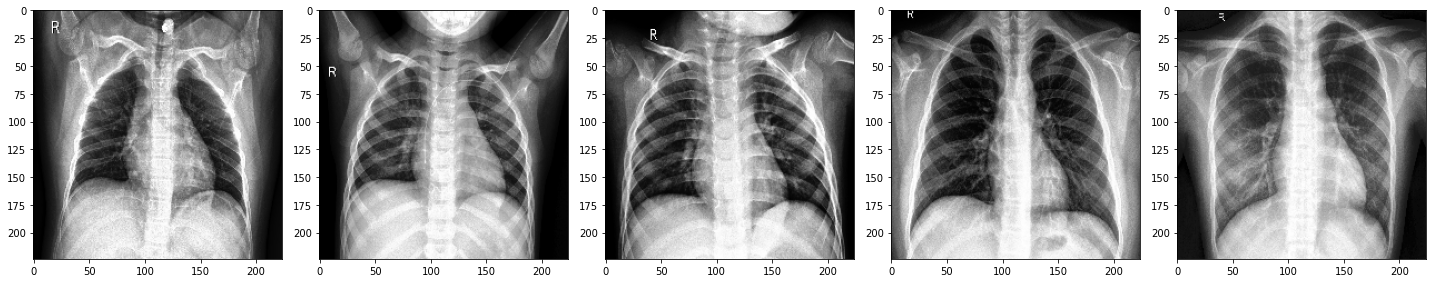

In [ ]:
# Função que plota 5 imagens do dataset (somente para visualização)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(data[:5]) 

In [ ]:
# Converte as imagens e rótulos para arrays NumPy, também escala os pixels entre 0 e 1
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
# Realiza a codificação one-hot (binarização) nos rótulos 
lb = LabelBinarizer()
labels = lb.fit_transform(labels) # positivo para 1, negativo para 0
labels = to_categorical(labels) 
print(labels)

In [ ]:
# Particiona as imagens numa divisão de 80% para treino e 20% para teste
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
																									    test_size = 0.20, 
																									    stratify = labels, 
																									    random_state = SEED)
# Resumo dos dados
print("[INFO] train: "+ str(len(X_train)))  
print("[INFO] test : "+ str(len(X_test)))  
print("[INFO] TOTAL: "+ str(len(data))) 

[INFO] train: 80
[INFO] test : 20
[INFO] TOTAL: 100


In [ ]:
# Inicializa o objeto de aumento de dados de treinamento (data augmentation) 
trainAug = ImageDataGenerator(rotation_range = 15,
															fill_mode = "nearest")
 

### Etapa 3: Construção do modelo


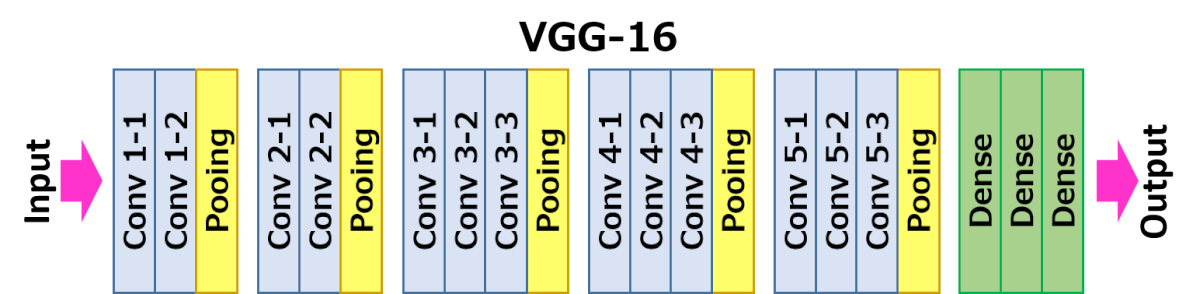

In [ ]:
# Transfer Learning

# VGG-16 é uma Rede Neural Convolucional treinada pela Universidade de Oxford
# O número 16 representa o número de camadas 

# Imagem conceitual
from IPython.display import Image
Image(filename = "/content/drive/MyDrive/tchelinux-2020/slides/vgg16.png")


In [ ]:
# Carrega a rede VGG16
baseModel = VGG16(weights = "imagenet", # pesos pré-treinados da ImageNet (ICLR 2015)
									include_top = False, # 3 camadas FC (Dense) descartadas
									input_tensor = Input(shape = (224, 224, 3)))

# baseModel.summary()

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# Constrói o head FC (camadas Densas) do modelo que será colocado em cima do modelo base (VGG-16)
headModel = baseModel.output
headModel = BatchNormalization()(headModel)
headModel = AveragePooling2D(pool_size = (4, 4))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(64, activation = "relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = "softmax")(headModel)

# Junta as redes
model = Model(inputs = baseModel.input, outputs = headModel)

# Faz um loop sobre todas as camadas no modelo base e as congela 
# para que não sejam atualizadas durante o primeiro processo de treinamento
for layer in baseModel.layers:
	layer.trainable = False


### Etapa 4: Treinamento do modelo


In [ ]:
# Compila o modelo
opt = Adam(lr = INIT_LR, decay = INIT_LR / EPOCHS) # otimizador gradiente descendente
model.compile(loss = "binary_crossentropy", 
							optimizer = opt, 
							metrics = ["accuracy"]) # número de acertos divido pelo total de exemplos

In [ ]:
# Treina a rede
print("[INFO] treinando RNA ... ")
H = model.fit(
							trainAug.flow(X_train, Y_train, batch_size = BS),
							steps_per_epoch = len(X_train) // BS,
							validation_data = (X_test, Y_test),
							validation_steps = len(X_test) // BS,
							epochs = EPOCHS, 
							verbose = 1,
							) 


[INFO] treinando RNA ... 
Epoch 1/3
80/80 [==============================] - 1s 18ms/step - loss: 0.5101 - accuracy: 0.7500 - val_loss: 0.6497 - val_accuracy: 0.5500
Epoch 2/3
80/80 [==============================] - 1s 15ms/step - loss: 0.1729 - accuracy: 1.0000 - val_loss: 0.4470 - val_accuracy: 0.8500
Epoch 3/3
80/80 [==============================] - 1s 15ms/step - loss: 0.0747 - accuracy: 0.9875 - val_loss: 0.3117 - val_accuracy: 0.8500


### Etapa 5: Avaliação do modelo

In [ ]:
# Geração dos gráficos de treinamento

# Atributos disponíveis
H.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

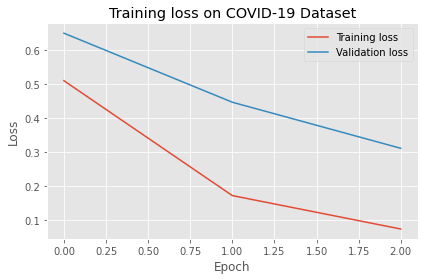

<Figure size 432x288 with 0 Axes>

In [ ]:
# Gráfico da função de perda (quanto menor, melhor)
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Training loss on COVID-19 Dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc = 'upper right')
plt.tight_layout()
plt.show()
plt.savefig(PLOT)

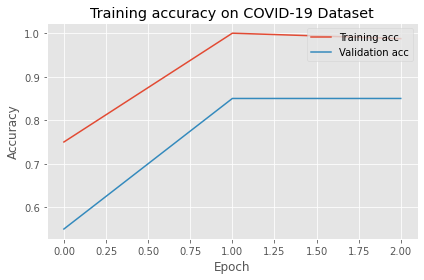

<Figure size 432x288 with 0 Axes>

In [ ]:
# Gráfico da acurácia (quanto maior, melhor)
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Training accuracy on COVID-19 Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training acc', 'Validation acc'], loc = 'upper right')
plt.tight_layout()
plt.show()
plt.savefig(PLOT)

In [ ]:
# Faz as predições no conjunto de testes (X_test)
print("[INFO] avaliando modelo ... \n")

pred_idxs = model.predict(X_test, batch_size = BS)

# para cada imagem no conjunto de teste encontra o índice do
# rótulo com a maior probabilidade prevista correspondente
pred_idxs = np.argmax(pred_idxs, axis = 1)

# calcula a matriz de confusão e usa para derivar a
# precisão, sensibilidade e especificidade
cm = confusion_matrix(Y_test.argmax(axis = 1), pred_idxs)
total = sum(sum(cm))

# accuracy: number of correct predictions / total number of predictions
acc = (cm[0, 0] + cm[1, 1]) / total

print("Confusion matrix: \n")
print(cm)
print("\nAccuracy: {:.4f} \n".format(acc))


[INFO] avaliando modelo ... 

Confusion matrix: 

[[8 2]
 [1 9]]

Accuracy: 0.8500 



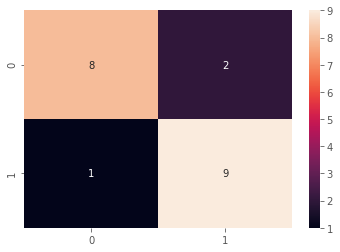

In [ ]:
# Gera a matriz graficamente
sns.heatmap(cm, annot = True)

In [ ]:
# Salva o modelo em disco
print("[INFO] salvando modelo detector de COVID-19 ...")
model.save(MODEL_SAVE, save_format = 'h5', overwrite = True)

[INFO] salvando modelo detector de COVID-19 ...
